In [84]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [85]:
from fastbook import *
from fastai.vision.widgets import *

In [86]:
key = os.environ.get('AZURE_SEARCH_KEY', '8466c9c4385649c2ad209aea6b71b0fa')

In [87]:
def search_images_bing(key, term, max_images: int = 200, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [111]:
characters_name = ['naruto uzumaki', 'kakashi hatake', 'jiraiya', 'tsunade', 'orochimaru', 'shikamaru nara', 'sasuke uchiha',
                  'itachi uchiha']
path = Path('characters')

In [112]:
if not path.exists():
    path.mkdir()
    for char in characters_name:
        dest = (path/char)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{char}')
        download_images(dest, urls=results.attrgot('contentUrl'))
        

KeyboardInterrupt: 

In [114]:
for char in characters_name:
    dest = (path/char)
    
    os.chdir(dest)
    for filename in os.listdir(dest):     
        new_filename = char[:3] + filename
        os.rename(filename, new_filename)
        

FileNotFoundError: [Errno 2] No such file or directory: 'characters/naruto uzumaki'

In [47]:
fns = get_image_files(path)
fns

(#1180) [Path('characters/uzumaki naruto/00000003.png'),Path('characters/uzumaki naruto/00000004.jpg'),Path('characters/uzumaki naruto/00000002.jpg'),Path('characters/uzumaki naruto/00000008.jpg'),Path('characters/uzumaki naruto/00000001.jpg'),Path('characters/uzumaki naruto/00000011.jpg'),Path('characters/uzumaki naruto/00000013.jpg'),Path('characters/uzumaki naruto/00000007.png'),Path('characters/uzumaki naruto/00000009.png'),Path('characters/uzumaki naruto/00000012.png')...]

In [48]:
failed = verify_images(fns)
failed

(#0) []

In [41]:
failed.map(Path.unlink);

FileNotFoundError: [Errno 2] No such file or directory: 'characters/hatake kakashi/00000102.jpg'

In [20]:
characters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
dls = characters.dataloaders(path)

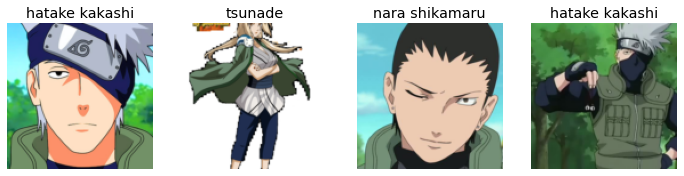

In [22]:
dls.valid.show_batch(max_n=4, nrows=1)

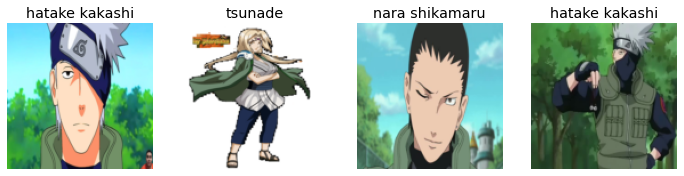

In [23]:
characters = characters.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

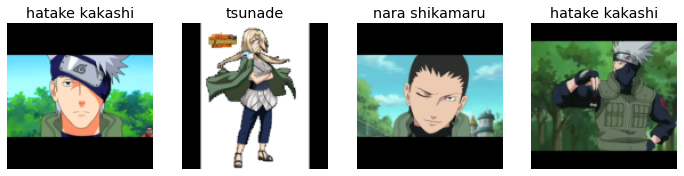

In [24]:
characters = characters.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = characters.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

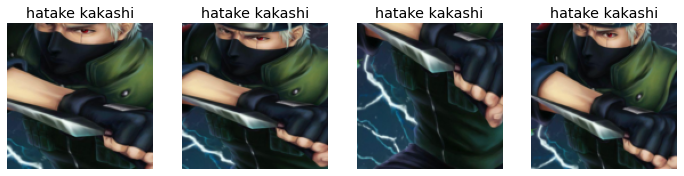

In [18]:
characters = characters.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = characters.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

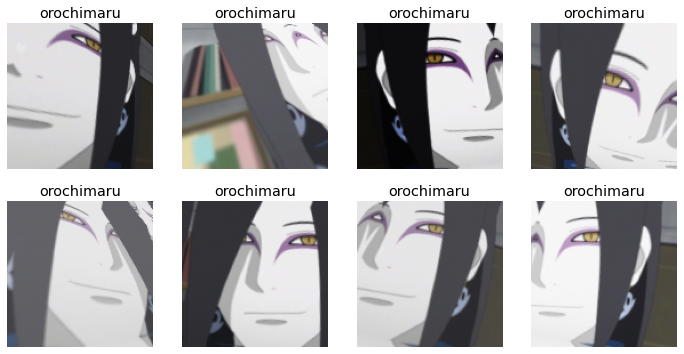

In [25]:
characters = characters.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = characters.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [26]:
characters = characters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = characters.dataloaders(path)

In [27]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.839157,1.217363,0.419492,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.445106,0.978648,0.343220,00:09
1,1.246356,0.768952,0.266949,00:09
2,1.039738,0.824287,0.271186,00:09
3,0.869351,0.801649,0.245763,00:09
4,0.730711,0.714225,0.245763,00:10
5,0.641627,0.720030,0.237288,00:09
6,0.563157,0.701928,0.237288,00:09
7,0.501212,0.697722,0.224576,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: U

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


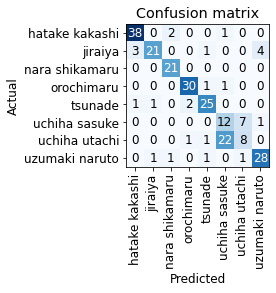

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

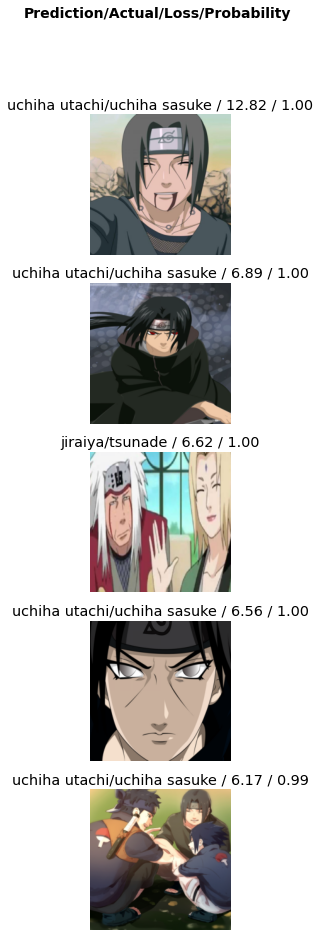

In [26]:
interp.plot_top_losses(5, nrows=5)

In [37]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/basics.py", line 211, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/load.py", line 125, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/load.py", line 131, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/core.py", line 314, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/core.py", line 314, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/core.py", line 280, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/data/core.py", line 242, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 198, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 150, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 73, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 83, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 89, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastcore/dispatch.py", line 117, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/vision/core.py", line 110, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/vision/core.py", line 85, in load_image
    im = Image.open(fn)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py", line 2878, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/naruto_classifier/characters/tsunade/00000138.jpg'


In [36]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

export.pkl is the trained model
below is a test predictions

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select a character!'), 
      btn_upload, btn_run, out_pl, lbl_pred])